In [ ]:
from preprocess import preprocess_data
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd, torch, numpy as np
from tqdm.auto import tqdm, trange

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

## Process data

In [ ]:
model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
df = pd.read_excel('./a_with_labels.xlsx')
df = df[['Text', 'my-label']].rename(columns={'Text': 'text', 'my-label': 'label'})

dataset = Dataset.from_pandas(df)

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

## Benchmark a model

In [ ]:
import time
from optimum.pipelines import pipeline
model_id = "cointegrated/rubert-tiny-sentiment-balanced"
classifier = pipeline(task="text-classification", accelerator="ort", model=model_id, device='cpu',truncation=True)

Device set to use cpu


In [ ]:
from collections import defaultdict

def benchmark(pipe, dataset):
    times, lengths = [], []
    for el in dataset:
        start = time.time()
        pipe(el['text'])
        lengths.append(len(pipe.tokenizer.tokenize(el['text'])))
        end = time.time()
        times.append(end - start)
    return np.array(lengths), np.array(times)

def group_for_plot(lengths, times):
    length_time_map = defaultdict(list)
    for length, time in zip(lengths, times): length_time_map[length].append(time)

    # Calculate averages
    unique_lengths = []
    average_times = []
    for length, time_list in length_time_map.items():
        unique_lengths.append(length)
        average_times.append(np.mean(time_list))

    # Sort for plotting
    sorted_indices = np.argsort(unique_lengths)
    unique_lengths = np.array(unique_lengths)[sorted_indices]
    average_times = np.array(average_times)[sorted_indices]
    return unique_lengths, average_times

In [ ]:
from benchmark import to_plotly
to_plotly(*benchmark(classifier, dataset['train']))

Token indices sequence length is longer than the specified maximum sequence length for this model (824 > 512). Running this sequence through the model will result in indexing errors


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'blue', 'opacity': 0.7},
              'mode': 'markers',
              'name': 'Individual Runs',
              'type': 'scatter',
              'x': {'bdata': ('DQAMAAoAAgAdAAIAEwAFABQAFgAVAB' ... 'UAcgA6ACUAQQACAAIAHwAJABEACgA='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAEB2dD8AAAAAgJJoPwAAAAAAZH' ... 'AAAGNQPwAAAAAAYmA/AAAAAIBicD8='),
                    'dtype': 'f8'}},
             {'line': {'color': 'red', 'width': 2},
              'mode': 'lines',
              'name': 'Average Time',
              'type': 'scatter',
              'x': {'bdata': ('AQACAAMABAAFAAYABwAIAAkACgALAA' ... 'B8AI4AlACeAMkAEwEeAVMB0QE4Aw=='),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAACUWD+rqqqqem9iPwAAAACAC1' ... 'AQdJM/AAAAACzCtT8AAAAAoOuxPw=='),
                    'dtype': 'f8'}}],
    'layout': {'legend': {'orientation': 'h', 'x': 0.5, 'xanchor': 'center'},
               'template': '...',
               'title': {'text': 'Run Time vs Sequence Length'},
               'xaxis': {'title': {'text': 'Sequence Length'}},
               'yaxis': {'title': {'text': 'Run Time (s)'}}}
})

### Other dataset

In [ ]:
from datasets import load_dataset

def map_sentiment(x):
    x['sentiment'] = {0: 'neutral', 1: 'positive', 2: 'negative'}[x['sentiment']]
    return x

dataset = load_dataset("MonoHime/ru_sentiment_dataset").remove_columns('Unnamed: 0')
dataset['test'] = dataset.pop('validation')
dataset = dataset.map(map_sentiment)
dataset = dataset.rename_column("sentiment", "label")

## Finetune a model

In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "cointegrated/rubert-tiny-sentiment-balanced"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()

In [ ]:
model.config.label2id

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_fn(tokenizer): 
    # this fixes multiprocessing issue
    def _f(x): return tokenizer(x["text"], truncation=True)
    return _f


ds = dataset.\
    map(tokenize_fn(tokenizer), batched=True, remove_columns=['text'], num_proc=1).\
    map(lambda x: {'label': [model.config.label2id[xl] for xl in x['label']]}, batched=True)

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

## Code for eval and predict

In [ ]:
from numpy import average
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

def predict(model, dl):
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(dl):
            batch = batch.to(model.device)
            logits = model(**batch).logits
            preds.append(logits.argmax(dim=-1)) 
            targets.append(batch["labels"])
    
    preds = torch.cat(preds).detach().cpu()
    targets = torch.cat(targets).detach().cpu()        
    return preds, targets


def do_eval(model, dl, agg=False):
    preds, targets = predict(model, dl)
    average = None if not agg else 'micro'
    metrics = {
        "accuracy": MulticlassAccuracy(average=average, num_classes=3),
        "precision": MulticlassPrecision(average=average, num_classes=3),
        "recall": MulticlassRecall(average=average, num_classes=3),
        "f1": MulticlassF1Score(average=average, num_classes=3),
    }
    results = {}
    for metric_name, metric_obj in metrics.items():
        metric_obj.update(preds, targets)
        if not agg: results[metric_name] = {model.config.id2label[i]:v.item() for i,v in enumerate(metric_obj.compute())}
        else: results[metric_name] = metric_obj.compute().item()
    return results

In [ ]:
import matplotlib.pyplot as plt

def update_graph(points: list[list], graph_ax, graph_out, names=None, x_bounds=None, y_bounds=None):
    graph_ax.clear()
    for i, p in enumerate(points): graph_ax.plot(*p, label=names[i] if names else None)
    graph_ax.legend(loc='upper right')
    if x_bounds is not None: graph_ax.set_xlim(*x_bounds)
    if y_bounds is not None: graph_ax.set_ylim(*y_bounds)
    graph_out.update(graph_ax.figure)

In [ ]:
def get_loss(model, dl):
    total_loss = 0.0
    total_batches = 0
    with torch.no_grad():
        for batch in tqdm(dl, leave=True):
            batch = batch.to(model.device)
            total_loss += model(**batch).loss.item()
            total_batches += 1
    return total_loss / total_batches if total_batches > 0 else 0.0

## Training loop

In [ ]:
from torch.utils.data import DataLoader

bs = 16
dl_train = DataLoader(ds["train"], shuffle=True, collate_fn=data_collator, batch_size=bs)
dl_test = DataLoader(ds["test"], shuffle=False, collate_fn=data_collator, batch_size=bs)

In [ ]:
do_eval(model, dl_train)

  0%|          | 0/29 [00:00<?, ?it/s]

e:\Python\RL\.conda\Lib\site-packages\torcheval\metrics\functional\classification\accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


{'accuracy': {'negative': 0.4193548262119293,
  'neutral': 0.7159090638160706,
  'positive': 0.7716049551963806},
 'precision': {'negative': 0.23636363446712494,
  'neutral': 0.807692289352417,
  'positive': 0.7440476417541504},
 'recall': {'negative': 0.4193548262119293,
  'neutral': 0.7159090638160706,
  'positive': 0.7716049551963806},
 'f1': {'negative': 0.302325576543808,
  'neutral': 0.7590361833572388,
  'positive': 0.7575757503509521}}

In [ ]:
from types import SimpleNamespace

config = SimpleNamespace(
n_epochs = 5,
window = 500,
cleanup_step = 100,
eval_step = 16
)
# reinitialize model in case we want to change parameters and restart training from scratch
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.n_epochs)

In [ ]:
weights = torch.tensor(ds['train']['label']).unique(return_counts=True)[1]
weights = weights/weights.sum()

In [ ]:
def loss_fn(logits, labels): return torch.nn.functional.cross_entropy(logits, labels, weight=weights.to(logits.device))

In [ ]:
model.train()
cleanup()

In [ ]:
def train(model, optimizer, dl_train, dl_test, config):
    fig, ax = plt.subplots(figsize=(9,4))
    graph_out = display(fig, display_id=True)
    eval_steps = []
    losses, test_losses = [], []
    step, ewm_loss = 0, 0
    try:
        for _ in trange(config.n_epochs):
            for i, batch in enumerate(tqdm(dl_train, leave=True)):
                step += 1
                batch = batch.to(model.device)
                output = model(**batch)
                loss = loss_fn(output.logits, batch['labels'])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # sched.step()
            
                
                if i % config.cleanup_step == 0: cleanup()

                w = 1 / min(i+1, config.window)
                ewm_loss = ewm_loss * (1-w) + loss.item() * w
                losses.append(loss.item())
                
                if i % config.eval_step == 0:
                    eval_steps.append(step)
                    model.eval()
                    eval_loss = get_loss(model, dl_test)
                    test_losses.append(eval_loss)
                    model.train()
                update_graph([[losses], [eval_steps, test_losses]], ax, graph_out, names=['loss', 'test loss'])
    except KeyboardInterrupt: print("Stopping training")

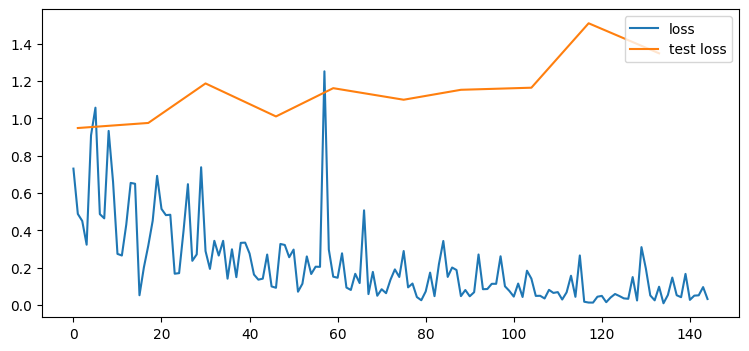

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

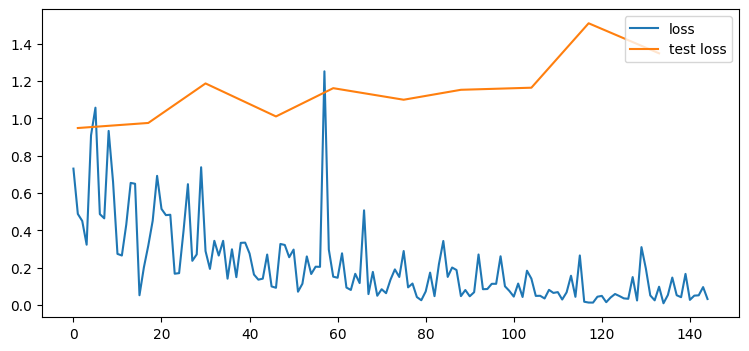

In [ ]:
train(model, optimizer, dl_train, dl_test, config)

In [ ]:
model.save_pretrained('./tuned_model_500_wce')

# Eval model

In [ ]:
do_eval(model, dl_test, agg=True)

  0%|          | 0/4 [00:00<?, ?it/s]

{'accuracy': 0.7058823704719543,
 'precision': 0.7058823704719543,
 'recall': 0.7058823704719543,
 'f1': 0.7058823704719543}

In [ ]:
model.to('cuda')

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [ ]:
do_eval(model.to('cuda'), dl_test)

  0%|          | 0/1 [00:00<?, ?it/s]

{'accuracy': 0.5686274766921997,
 'precision': 0.5373897552490234,
 'recall': 0.7066666483879089,
 'f1': 0.4532356560230255}

<torch.utils.data.dataloader.DataLoader>